In [80]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

# import plotting related libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from matplotlib import colors
import matplotlib
import matplotlib.patches as mpatches

In [2]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

In [5]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']
BS_24hr_8am = np.zeros((len(date),), dtype = int)
BS_24hr_8am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12pm = np.zeros((len(date),), dtype = int)
BS_24hr_12pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4pm = np.zeros((len(date),), dtype = int)
BS_24hr_4pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_8pm = np.zeros((len(date),), dtype = int)
BS_24hr_8pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12am = np.zeros((len(date),), dtype = int)
BS_24hr_12am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4am = np.zeros((len(date),), dtype = int)
BS_24hr_4am_tran = np.zeros((len(date),), dtype = int)

In [6]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [7]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am[d] = num
    BS_24hr_12am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "04", "04", 'west-us')
    BS_24hr_4am[d] = num
    BS_24hr_4am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "08", "08", 'west-us')
    BS_24hr_8am[d] = num
    BS_24hr_8am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "12", "12", 'west-us')
    BS_24hr_12pm[d] = num
    BS_24hr_12pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "16", "16", 'west-us')
    BS_24hr_4pm[d] = num
    BS_24hr_4pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "20", "20", 'west-us')
    BS_24hr_8pm[d] = num
    BS_24hr_8pm_tran[d] = tran
    


In [8]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

__Timimg 12am__

Avg err.

Spacing : 24hr

Duration : <1m, 5m, 30m, 1hr, 2hr>

In [9]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']

time_1_1 = ["00:00:00", "02:00:00", "04:00:00", "06:00:00"]
time_1_diff = [["02:00:00", "04:00:00", "06:00:00", "08:00:00"], ["01:00:00", "03:00:00", "05:00:00", "07:00:00"], ["00:30:00", "02:30:00", "04:30:00", "06:30:00"], ["00:05:00", "02:05:00", "04:05:00", "06:05:00"], ["00:01:00", "02:01:00", "04:01:00", "06:01:00"]]

# time_2_1 = ["12:00:00", "14:00:00", "16:00:00", "18:00:00"]
# time_2_diff = [["14:00:00", "16:00:00", "18:00:00", "20:00:00"], ["13:00:00", "15:00:00", "17:00:00", "19:00:00"], ["12:30:00", "14:30:00", "16:30:00", "18:30:00"], ["12:05:00", "14:05:00", "16:05:00", "18:05:00"], ["12:01:00", "14:01:00", "16:01:00", "18:01:00"]]



# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

In [10]:
estimate_N_24hr_diff_12am = [np.zeros((len(date))) for i in range(5)]
C_tran_24hr_diff_12am = [np.zeros((len(date)), dtype = int) for i in range(5)]

In [11]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((len(date), len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], j, 'west-us')

    R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
    for d, _ in enumerate(date):
        R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

    for d in range(len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_24hr_diff_12am[index] = N_t
    C_tran_24hr_diff_12am[index] = C_tran
    print(estimate_N_24hr_diff_12am[index])
    # print(C_tran_24hr_12am)

[  0.          85.          87.36639754 121.66666667 115.78494624
 124.3706059  119.98319328  71.74509804  53.05959246  52.
  52.          52.          52.        ]
[  0.          73.          74.89119569 108.54208145  87.
 110.25        65.31451613  50.          50.          50.
  50.          50.          50.        ]
[  0.    49.98  50.    50.    50.   107.31  50.    50.    50.    50.
  50.    50.    50.  ]
[ 0.         52.21052632 48.125      48.80769231 50.52631579 73.65306122
 51.04166667 50.42857143 51.03571429 50.2        39.90909091 24.
 24.        ]
[  0.          30.33333333  38.87407407  81.          37.4
 110.          46.5         85.525       40.80681818  54.16666667
  23.          11.          13.75      ]


In [70]:
avg_24hr_diff_num = []
avg_24hr_err = []

for i in range(len(estimate_N_24hr_diff_12am)):
    avg_24hr_diff_num = []
    for j in range(len(estimate_N_24hr_diff_12am[0])):
        avg_24hr_diff_num.append(BS_24hr_12am[j]-estimate_N_24hr_diff_12am[i][j])
    avg_24hr_diff_num = np.divide(avg_24hr_diff_num, len(estimate_N_24hr_diff_12am[0]))
    avg_24hr_err.append(avg_24hr_diff_num)
print(avg_24hr_err)
avg_24hr_err_plot = []
for i in range(len(avg_24hr_err)):
    avg_24hr_err_plot.append(np.divide(np.sum(avg_24hr_err[i]), 100))
    # avg_24hr_err_plot.append(np.sum(avg_24hr_err[i]))
print(avg_24hr_err_plot)

[array([10.07692308,  3.84615385,  3.35643096,  0.79487179,  1.93961952,
        0.27918416,  2.46283129,  4.71191554,  6.68772366,  7.69230769,
        5.84615385,  6.        ,  6.07692308]), array([10.07692308,  4.76923077,  4.31606187,  1.80445527,  4.15384615,
        1.36538462,  6.66811414,  6.38461538,  6.92307692,  7.84615385,
        6.        ,  6.15384615,  6.23076923]), array([10.07692308,  6.54      ,  6.23076923,  6.30769231,  7.        ,
        1.59153846,  7.84615385,  6.38461538,  6.92307692,  7.84615385,
        6.        ,  6.15384615,  6.23076923]), array([10.07692308,  6.36842105,  6.375     ,  6.39940828,  6.95951417,
        4.18053375,  7.76602564,  6.35164835,  6.84340659,  7.83076923,
        6.77622378,  8.15384615,  8.23076923]), array([10.07692308,  8.05128205,  7.08660969,  3.92307692,  7.96923077,
        1.38461538,  8.11538462,  3.65192308,  7.63024476,  7.52564103,
        8.07692308,  9.15384615,  9.01923077])]
[0.5977103845202965, 0.7269247744069538

Avg err.

Spacing : 8hr

Duration : <1m, 5m, 30m, 1hr, 2hr>

In [12]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", "02:00:00", "04:00:00", "06:00:00"]
time_1_diff = [["02:00:00", "04:00:00", "06:00:00", "08:00:00"], ["01:00:00", "03:00:00", "05:00:00", "07:00:00"], ["00:30:00", "02:30:00", "04:30:00", "06:30:00"], ["00:05:00", "02:05:00", "04:05:00", "06:05:00"], ["00:01:00", "02:01:00", "04:01:00", "06:01:00"]]

time_2_1 = ["08:00:00", "10:00:00", "12:00:00", "14:00:00"]
time_2_diff = [["10:00:00", "12:00:00", "14:00:00", "16:00:00"], ["09:00:00", "11:00:00", "13:00:00", "15:00:00"], ["08:30:00", "10:30:00", "12:30:00", "14:30:00"], ["08:05:00", "10:05:00", "12:05:00", "14:05:00"], ["08:01:00", "10:01:00", "12:01:00", "14:01:00"]]

time_3_1 = ["16:00:00", "18:00:00", "20:00:00", "22:00:00"]
time_3_diff = [["18:00:00", "20:00:00", "22:00:00", "23:59:59"], ["17:00:00", "19:00:00", "21:00:00", "23:00:00"], ["16:30:00", "18:30:00", "20:30:00", "22:30:00"], ["16:05:00", "18:05:00", "20:05:00", "22:05:00"], ["16:01:00", "18:01:00", "20:01:00", "22:01:00"]]



# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

In [13]:
estimate_N_8hr_diff_12am = [np.zeros(3*(len(date))) for i in range(5)]
C_tran_8hr_diff_12am = [np.zeros(3*(len(date)), dtype = int) for i in range(5)]

In [14]:
for index in range(len(time_1_diff)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[0], time_2_diff[index][0], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[0], time_3_diff[index][0], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr_diff_12am[index] = N_t
    C_tran_8hr_diff_12am[index] = C_tran
    print(estimate_N_8hr_diff_12am[index])

[  0.          85.         102.         102.         128.07184677
 127.0079995  129.99000384 126.         126.         126.
 126.         134.03844675 126.         128.04878049 128.
 128.         129.056256   129.42222222 130.075      130.
 131.56161092 130.         134.14840446 130.         134.14840446
 140.85233051 129.21648335 128.         128.         128.09401709
 127.         127.         129.94355644 126.         126.
 126.0661157  122.         123.41414141 108.        ]
[  0.          79.          99.28378378  98.         127.63657721
 124.992      128.95040369 125.         125.         125.
 125.         128.95040369 125.         126.19047619 126.
 126.         129.46456908 129.55246914 128.984375   128.
 130.56582633 127.         127.         127.         127.
 127.         131.029604   127.         127.         127.
 127.         127.         128.49019608 126.         127.13559322
 125.11965812 118.         121.13953488 100.        ]
[  0.          49.98        82.35294118 

In [72]:
avg_8hr_err = []

for i in range(len(estimate_N_8hr_diff_12am)):
    avg_8hr_diff_num = []
    for j in range(len(estimate_N_8hr_diff_12am[0])):
        avg_8hr_diff_num.append(BS_24hr_12am[j//3]-estimate_N_8hr_diff_12am[i][j])
    # print(avg_8hr_diff_num)
    avg_8hr_diff_num = np.divide(avg_8hr_diff_num, len(estimate_N_8hr_diff_12am[0]))
    avg_8hr_err.append(avg_8hr_diff_num)
# print(avg_8hr_err)

avg_8hr_err_plot = []
for i in range(len(avg_8hr_err)):
    avg_8hr_err_plot.append(np.divide(np.sum(avg_8hr_err[i]), 100))
print(avg_8hr_err_plot)

[0.13380625130054213, 0.15602936655949756, 0.20224490903874884, 0.7194598500030108, 0.8264581896050732]


Avg err.

Spacing : 4hr

Duration : <1m, 5m, 30m, 1hr, 2hr>

In [15]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", '01:00:00', '02:00:00', '03:00:00']
time_1_diff = [['02:00:00', '04:00:00', '06:00:00', '08:00:00'],["01:00:00", '02:00:00', '03:00:00', '04:00:00'], ['00:30:00', '01:30:00', '02:30:00', '03:30:00'], ['00:05:00', '01:05:00', '02:05:00', '03:05:00'], ['00:01:00', '01:01:00', '02:01:00', '03:01:00']]

time_2_1 = ['04:00:00', '05:00:00', '06:00:00', '07:00:00']
time_2_diff = [['06:00:00', '07:00:00', '08:00:00', '09:00:00'], ['05:00:00', '06:00:00', '07:00:00', '08:00:00'], ['04:30:00', '05:30:00', '06:30:00', '07:30:00'], ['04:05:00', '05:05:00', '06:05:00', '07:05:00'], ['04:01:00', '05:01:00', '06:01:00', '07:01:00']]

time_3_1 = ['08:00:00', '09:00:00', '10:00:00', '11:00:00']
time_3_diff = [['10:00:00', '11:00:00', '12:00:00', '13:00:00'], ['09:00:00', '10:00:00', '11:00:00', '12:00:00'], ['08:30:00', '09:30:00', '10:30:00', '11:30:00'],  ['08:05:00', '09:05:00', '10:05:00', '11:05:00'], ['08:01:00', '09:01:00', '10:01:00', '11:01:00']]

time_4_1 = ['12:00:00', '13:00:00', '14:00:00', '15:00:00']
time_4_diff = [['14:00:00', '15:00:00', '16:00:00', '17:00:00'], ['13:00:00', '14:00:00', '15:00:00', '16:00:00'], ['12:30:00', '13:30:00', '14:30:00', '15:30:00'], ['12:05:00', '13:05:00', '14:05:00', '15:05:00'], ['12:01:00', '13:01:00', '14:01:00', '15:01:00']]

time_5_1 = ['16:00:00', '17:00:00', '18:00:00', '19:00:00']
time_5_diff = [['18:00:00', '19:00:00', '20:00:00', '21:00:00'], ['17:00:00', '18:00:00', '19:00:00', '20:00:00'], ['16:30:00', '17:30:00', '18:30:00', '19:30:00'], ['16:05:00', '17:05:00', '18:05:00', '19:05:00'], ['16:01:00', '17:01:00', '18:01:00', '19:01:00']]

time_6_1 = ['20:00:00', '21:00:00', '22:00:00', '23:00:00']
time_6_diff = [['22:00:00', '23:00:00', '23:59:59', '23:59:59'],  ['21:00:00', '22:00:00', '23:00:00', '23:59:59'], ['20:30:00', '21:30:00', '22:30:00', '23:30:00'], ['20:05:00', '21:05:00', '22:05:00', '23:05:00'], ['20:01:00', '21:01:00', '22:01:00', '23:01:00']]

# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

In [16]:
estimate_N_4hr_diff_12am = [np.zeros(6*(len(date))) for i in range(5)]
C_tran_4hr_diff_12am = [np.zeros(6*(len(date)), dtype = int) for i in range(5)]

In [17]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[0], time_2_diff[index][0], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[0], time_3_diff[index][0], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[0], time_4_diff[index][0], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[0], time_5_diff[index][0], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[0], time_6_diff[index][0], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr_diff_12am[index] = N_t
    C_tran_4hr_diff_12am[index] = C_tran
    print(estimate_N_4hr_diff_12am[index])

[  0.          87.3010355   85.         127.5        127.
 127.         127.         129.35185185 130.11570248 131.06557377
 132.08767952 131.         133.56862745 132.         132.
 133.10361552 132.         134.53846154 133.         133.
 133.         136.23065476 141.9928356  145.04281272 134.
 135.35353535 136.08870968 136.         136.         136.
 136.         136.         137.184768   136.         137.51111111
 137.         137.         137.         137.         138.096
 138.         138.         138.         138.5505618  141.42560554
 137.         137.         137.         138.68627451 136.
 141.39267227 130.064      129.21648335 128.         128.
 128.         128.         128.         128.09401709 127.
 127.         127.         127.         127.         129.94355644
 126.         126.         126.         126.         126.
 126.01612903 127.35573333 125.         125.         125.23423423
 125.15870622 108.          60.        ]
[  0.          79.          79.         124.42

In [73]:
avg_4hr_err = []

for i in range(len(estimate_N_4hr_diff_12am)):
    avg_4hr_diff_num = []
    for j in range(len(estimate_N_4hr_diff_12am[0])):
        avg_4hr_diff_num.append(BS_24hr_12am[j//6]-estimate_N_4hr_diff_12am[i][j])
    # print(avg_4hr_diff_num)
    avg_4hr_diff_num = np.divide(avg_4hr_diff_num, len(estimate_N_4hr_diff_12am[0]))
    avg_4hr_err.append(avg_4hr_diff_num)
# print(avg_8hr_err)

avg_4hr_err_plot = []
for i in range(len(avg_4hr_err)):
    avg_4hr_err_plot.append(np.divide(np.sum(avg_4hr_err[i]), 100))
print(avg_4hr_err_plot)

[0.07470885273391428, 0.12457186304817731, 0.15112181413796022, 0.4566590157227873, 0.5935348756087496]


Avg err.

Spacing : 2hr

Duration : <1m, 5m, 30m, 1hr, (2hr)>

In [48]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", '01:00:00', '02:00:00', '03:00:00']
time_1_diff = [['02:00:00', '04:00:00', '06:00:00', '08:00:00'],["01:00:00", '02:00:00', '03:00:00', '04:00:00'], ['00:30:00', '01:30:00', '02:30:00', '03:30:00'], ['00:05:00', '01:05:00', '02:05:00', '03:05:00'], ['00:01:00', '01:01:00', '02:01:00', '03:01:00']]

time_2_1 = ["02:00:00", '03:00:00', '04:00:00', '05:00:00']
time_2_diff = [['04:00:00', '05:00:00', '06:00:00', '07:00:00'],['03:00:00', '04:00:00', '05:00:00', '06:00:00'], ['02:30:00', '03:30:00', '04:30:00', '05:30:00'], ['02:05:00', '03:05:00', '04:05:00', '05:05:00'], ['02:01:00', '03:01:00', '04:01:00', '05:01:00']]

time_3_1 = ['04:00:00', '05:00:00', '06:00:00', '07:00:00']
time_3_diff = [['06:00:00', '07:00:00', '08:00:00', '09:00:00'], ['05:00:00', '06:00:00', '07:00:00', '08:00:00'], ['04:30:00', '05:30:00', '06:30:00', '07:30:00'], ['04:05:00', '05:05:00', '06:05:00', '07:05:00'], ['04:01:00', '05:01:00', '06:01:00', '07:01:00']]

time_4_1 = ['06:00:00', '07:00:00', '08:00:00', '09:00:00']
time_4_diff = [['08:00:00', '09:00:00', '10:00:00', '11:00:00'], ['07:00:00', '08:00:00', '09:00:00', '10:00:00'], ['06:30:00', '07:30:00', '08:30:00', '09:30:00'], ['06:05:00', '07:05:00', '08:05:00', '09:05:00'], ['06:01:00', '07:01:00', '08:01:00', '09:01:00']]

time_5_1 = ['08:00:00', '09:00:00', '10:00:00', '11:00:00']
time_5_diff = [['10:00:00', '11:00:00', '12:00:00', '13:00:00'], ['09:00:00', '10:00:00', '11:00:00', '12:00:00'], ['08:30:00', '09:30:00', '10:30:00', '11:30:00'],  ['08:05:00', '09:05:00', '10:05:00', '11:05:00'], ['08:01:00', '09:01:00', '10:01:00', '11:01:00']]

time_6_1 = ['10:00:00', '11:00:00', '12:00:00', '13:00:00']
time_6_diff = [['12:00:00', '13:00:00', '14:00:00', '15:00:00'], ['11:00:00', '12:00:00', '13:00:00', '14:00:00'], ['10:30:00', '11:30:00', '12:30:00', '13:30:00'],  ['10:05:00', '11:05:00', '12:05:00', '13:05:00'], ['10:01:00', '11:01:00', '12:01:00', '13:01:00']]

time_7_1 = ['12:00:00', '13:00:00', '14:00:00', '15:00:00']
time_7_diff = [['14:00:00', '15:00:00', '16:00:00', '17:00:00'], ['13:00:00', '14:00:00', '15:00:00', '16:00:00'], ['12:30:00', '13:30:00', '14:30:00', '15:30:00'], ['12:05:00', '13:05:00', '14:05:00', '15:05:00'], ['12:01:00', '13:01:00', '14:01:00', '15:01:00']]

time_8_1 = ['14:00:00', '15:00:00', '16:00:00', '17:00:00']
time_8_diff = [['16:00:00', '17:00:00', '18:00:00', '19:00:00'], ['15:00:00', '16:00:00', '17:00:00', '18:00:00'], ['14:30:00', '15:30:00', '16:30:00', '17:30:00'], ['14:05:00', '15:05:00', '16:05:00', '17:05:00'], ['14:01:00', '15:01:00', '16:01:00', '17:01:00']]

time_9_1 = ['16:00:00', '17:00:00', '18:00:00', '19:00:00']
time_9_diff = [['18:00:00', '19:00:00', '20:00:00', '21:00:00'], ['17:00:00', '18:00:00', '19:00:00', '20:00:00'], ['16:30:00', '17:30:00', '18:30:00', '19:30:00'], ['16:05:00', '17:05:00', '18:05:00', '19:05:00'], ['16:01:00', '17:01:00', '18:01:00', '19:01:00']]

time_10_1 = ['18:00:00', '19:00:00', '20:00:00', '21:00:00']
time_10_diff = [['20:00:00', '21:00:00', '22:00:00', '23:00:00'], ['19:00:00', '20:00:00', '21:00:00', '22:00:00'], ['18:30:00', '19:30:00', '20:30:00', '21:30:00'], ['18:05:00', '19:05:00', '20:05:00', '21:05:00'], ['18:01:00', '19:01:00', '20:01:00', '21:01:00']]

time_11_1 = ['20:00:00', '21:00:00', '22:00:00', '23:00:00']
time_11_diff = [['22:00:00', '23:00:00', '23:59:59', '23:59:59'],  ['21:00:00', '22:00:00', '23:00:00', '23:59:59'], ['20:30:00', '21:30:00', '22:30:00', '23:30:00'], ['20:05:00', '21:05:00', '22:05:00', '23:05:00'], ['20:01:00', '21:01:00', '22:01:00', '23:01:00']]

time_12_1 = ['22:00:00', '23:00:00', '23:59:59', '23:59:59']
time_12_diff = [['23:59:59', '23:00:00', '23:59:59', '23:59:59'],  ['23:00:00', '22:00:00', '23:00:00', '23:59:59'], ['22:30:00', '21:30:00', '22:30:00', '23:30:00'], ['22:05:00', '21:05:00', '22:05:00', '23:05:00'], ['22:01:00', '21:01:00', '22:01:00', '23:01:00']]

# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

In [49]:
estimate_N_2hr_diff_12am = [np.zeros(12*(len(date))) for i in range(5)]
C_tran_2hr_diff_12am = [np.zeros(12*(len(date)), dtype = int) for i in range(5)]

In [50]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((12*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], 12*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[0], time_2_diff[index][0], 12*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[0], time_3_diff[index][0], 12*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[0], time_4_diff[index][0], 12*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[0], time_5_diff[index][0], 12*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[0], time_6_diff[index][0], 12*j+5, 'west-us')
        get_server_ip_sampling(d, time_7_1[0], time_7_diff[index][0], 12*j+6, 'west-us')
        get_server_ip_sampling(d, time_8_1[0], time_8_diff[index][0], 12*j+7, 'west-us')
        get_server_ip_sampling(d, time_9_1[0], time_9_diff[index][0], 12*j+8, 'west-us')
        get_server_ip_sampling(d, time_10_1[0], time_10_diff[index][0], 12*j+9, 'west-us')
        get_server_ip_sampling(d, time_11_1[0], time_11_diff[index][0], 12*j+10, 'west-us')
        get_server_ip_sampling(d, time_12_1[0], time_12_diff[index][0], 12*j+11, 'west-us')

    R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
    for d in range(12*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

    for d in range(12*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_2hr_diff_12am[index] = N_t
    C_tran_2hr_diff_12am[index] = C_tran
    print(estimate_N_2hr_diff_12am[index])

[  0.         116.31578947 115.17307692 120.55172414 119.
 121.16363636 131.21206303 131.26213592 131.         132.65822785
 132.         134.44444444 133.         133.         135.46296296
 134.         136.21487603 136.         137.1147541  137.
 138.18329554 138.85135135 138.         138.         140.70588235
 139.         139.         140.6746988  140.         140.
 141.23110355 140.         140.         142.74509804 143.71153846
 142.         142.         142.         142.         143.79746835
 143.         144.93243243 146.26771654 146.         150.66974852
 146.         155.32262071 147.         147.         147.
 148.48484848 148.         148.         148.         148.
 148.         148.         148.         148.         148.
 148.         148.         148.         148.         149.377536
 174.32200358 149.         149.         150.65555556 151.48965235
 150.         150.         150.         150.         150.
 150.         150.         151.2        152.208      154.32242439
 1

In [108]:
avg_2hr_err = []

for i in range(len(estimate_N_2hr_diff_12am)):
    avg_2hr_diff_num = []
    for j in range(len(estimate_N_2hr_diff_12am[0])):
        avg_2hr_diff_num.append(BS_24hr_12am[j//12]-estimate_N_2hr_diff_12am[i][j])
    # print(avg_2hr_diff_num)
    avg_2hr_diff_num = np.divide(avg_2hr_diff_num, len(estimate_N_2hr_diff_12am[0]))
    avg_2hr_err.append(avg_2hr_diff_num)
# print(avg_2hr_err)

avg_2hr_err_plot = []
for i in range(len(avg_2hr_err)):
    avg_2hr_err_plot.append(abs(np.divide(np.sum(avg_2hr_err[i]), 100)))
print(avg_2hr_err_plot)

[0.03410464104287295, 0.07067286891693651, 0.10018612941427282, 0.32206235701575653, 0.48169946853518975]


Visualization

In [89]:
%matplotlib inline

In [109]:
avg_2hr_err_plot.reverse()
avg_4hr_err_plot.reverse()
avg_8hr_err_plot.reverse()
avg_24hr_err_plot.reverse()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

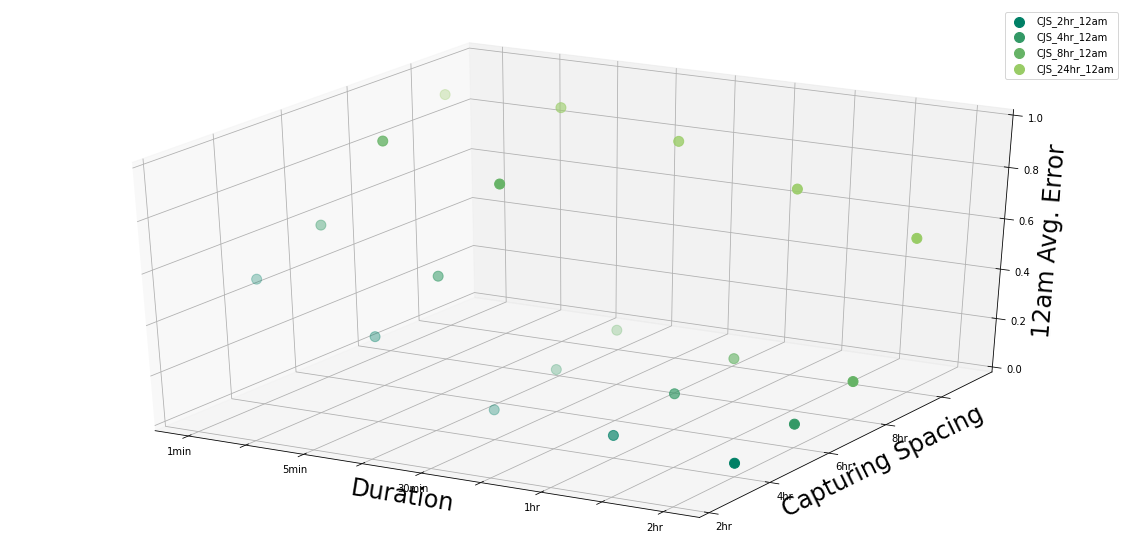

In [110]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
color_idx = np.linspace(0, 1, 6)
x_axis = np.arange(0,1,0.2)
y_axis = np.arange(0,5,1)

ax.scatter3D(x_axis, avg_2hr_err_plot, zs = 0.2, zdir='y', c=plt.cm.summer(color_idx[0]), label='CJS_2hr_12am', s=100)
ax.scatter(x_axis, avg_4hr_err_plot, zs = 0.4, zdir='y', c=plt.cm.summer(color_idx[1]), label='CJS_4hr_12am', s=100)
ax.scatter(x_axis, avg_8hr_err_plot, zs = 0.6, zdir='y', c=plt.cm.summer(color_idx[2]), label='CJS_8hr_12am', s=100)
ax.scatter(x_axis, avg_24hr_err_plot, zs = 0.8, zdir='y', c=plt.cm.summer(color_idx[3]), label='CJS_24hr_12am', s=100)

ax.legend()
ax.set_xlabel('Duration', fontsize=24)
label_x = ['', '1min', '', '5min', '', '30min', '', '1hr', '', '2hr']
ax.set_xticklabels(label_x)
ax.set_ylabel('Capturing Spacing', fontsize=24)
label_y = ['', '2hr', '4hr',  '6hr', '8hr']
ax.set_yticklabels(label_y)
ax.set_zlabel('12am Avg. Error', fontsize=24)
ax.set_zlim(0, 1)

plt.show()


In [53]:
x_axis = np.arange(0,4,1)
print(x_axis)

[0 1 2 3]
